In [1]:
import sys
!{sys.executable} -m pip install pymystem3

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import re
import os
import sys
import subprocess
import logging
import itertools
from collections import defaultdict
from IPython.display import HTML, Image, display

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import ipywidgets as widgets

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S', stream=sys.stdout)

sns.set(style="darkgrid", font_scale=1.2)
print("numpy {}, pandas {}, seaborn: {}".format(
    np.__version__, pd.__version__, sns.__version__
))

numpy 1.18.5, pandas 1.1.1, seaborn: 0.10.0


**References**: There are many discussions on Kaggle about the feature extractions. Many ideas are similar. I refer to this [notebook](https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3) for ideas.

# Load data

In [3]:
DATA_DIR = "data"

In [4]:
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))
shops = pd.read_csv(os.path.join(DATA_DIR, 'shops.csv'))
item_cats = pd.read_csv(os.path.join(DATA_DIR, 'item_categories.csv'))
sales = pd.read_csv(os.path.join(DATA_DIR, 'sales_train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

## Data Cleaning and Preprocessing

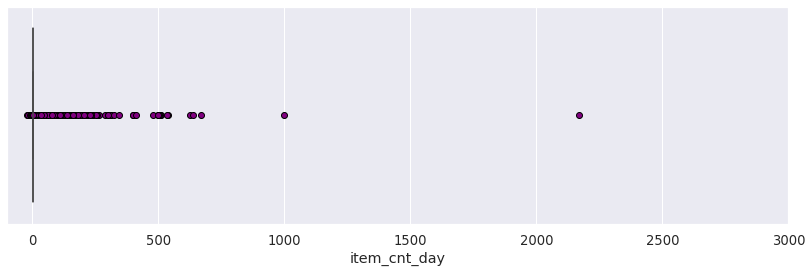

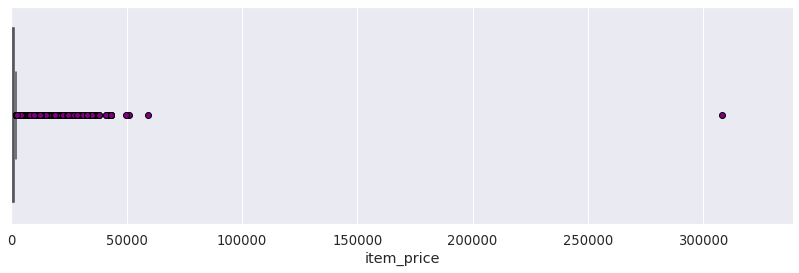

In [5]:
plt.figure(figsize=(14, 4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(14,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price, flierprops=flierprops)

Filter out the outliers in price and item_cnt_day

In [6]:
# filter out the outliers in price and item_cnt_day
def filter_outliers(df):
    df = df[(df.item_price < 300000) & (df.item_cnt_day < 1000)]
    df = df[df.item_price > 0].reset_index(drop=True)
    df.loc[df.item_cnt_day < 1, "item_cnt_day"] = 0
    return df

sales = filter_outliers(sales)

Some shop names are very similar. We can merge them together. 

In [7]:
# Якутск Орджоникидзе, 56
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Extract city and category from shop names

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()

shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])
shops["category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])

For shop categories with less than 5 shops, we can group them together to "other" category

In [9]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply(lambda x: x if (x in category) else "other")

label encoding the category and city

In [10]:
shops["shop_category"] = LabelEncoder().fit_transform(shops.category)
shops["shop_city"] = LabelEncoder().fit_transform(shops.city)
shops = shops[["shop_id", "shop_category", "shop_city"]]

For the item_category name, we can extract the main category and subcategory. For example, in 'Аксессуары - PS4', the main category is Accessory, and the subcategory is PS4.

In [11]:
item_cats["type_code"] = item_cats.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
category = []
for cat in item_cats.type_code.unique():
    if len(item_cats[item_cats.type_code == cat]) >= 5: 
        category.append(cat)
item_cats.type_code = item_cats.type_code.apply(lambda x: x if (x in category) else "etc")
item_cats.type_code = LabelEncoder().fit_transform(item_cats.type_code)

item_cats["split"] = item_cats.item_category_name.apply(lambda x: x.split("-"))
item_cats["subtype"] = item_cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats["subtype_code"] = LabelEncoder().fit_transform( item_cats["subtype"] )
item_cats = item_cats[["item_category_id", "subtype_code", "type_code"]]

Clean up item data

In [12]:
pd.set_option('display.max_colwidth', None)
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) D,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [13]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [14]:
# preprocess russian text: https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
import re
import nltk
nltk.download("stopwords")

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    text = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', text) # remove special characters
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [15]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: preprocess_text(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply(lambda x: x[:-1] if x !="0" else "0")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
def calc_tfidf_features():
    tfidf = TfidfVectorizer(max_features=25)
    text_features = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
    text_features = text_features.rename(columns=lambda x: "tfidf_{}".format(x))
    for c in text_features.columns:
        if re.match('^tfidf', c):
            text_features[c] = text_features[c].astype("float16")
    return pd.concat([items[['item_id']], text_features], axis=1)

In [17]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )

if the number of items for a type extracted from name2 is smaller than 40, we group them into "other"

In [18]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items = items.merge(
            calc_tfidf_features(),
            on=['item_id'], how='left'
        )

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,...,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24
0,0,40,4,1331,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,76,64,42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.403564,0.0,0.0,0.0,0.0,0.0,0.0,0.483887
2,2,40,4,1011,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,40,4,1010,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,40,4,1572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Preparing the feature matrix

Create a grid of every possible combination of (date_block_month, shop_id, item_id). We will get the sales volume and extract features for all such combinations.

In [19]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    trans = sales[sales.date_block_num == i]
    matrix.append(np.array(list(product([i],trans.shop_id.unique(), trans.item_id.unique())), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

21.486947774887085

In [20]:
# Daily revenue for the item at a particular shop
sales["revenue"] = sales["item_cnt_day"] * sales["item_price"]

Get the monthly sales for (shop_id, item_id) since we are predicting at monthly granularity not at daily granularity

In [21]:
ts = time.time()
group = sales.groupby( ["date_block_num", "shop_id", "item_id"]).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts


5.675267219543457

Concatenate the train and test data together for ease of feature extraction

In [22]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [23]:
ts = time.time()
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0,inplace = True )
time.time() - ts

0.06354594230651855

Join the sales data with shop data, item data, and item category data

In [24]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, item_cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int16)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

6.781126260757446

In [25]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,tfidf_0,...,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,0.0,...,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,4,5
1,0,2,27,1.0,4,0,19,76,42,0.0,...,0.453857,0.0,0.0,0.0,0.543945,0.0,0.0,0.0,10,3
2,0,2,28,0.0,4,0,30,107,42,0.0,...,0.487305,0.0,0.0,0.0,0.583984,0.0,0.0,0.0,55,3
3,0,2,29,0.0,4,0,23,123,42,0.0,...,0.363525,0.0,0.0,0.0,0.435547,0.0,0.0,0.0,16,3
4,0,2,32,0.0,4,0,40,4,42,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4,5


## Time lagging features

In [26]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print("Generating lagging feature for {}".format(col))
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

### last 1, 2, 3 months' monthly sales

In [27]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

Generating lagging feature for item_cnt_month


27.00270390510559

### last 1,2,3 month's average monthly sales

In [28]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_avg_item_cnt"] )
matrix.drop(["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

Generating lagging feature for date_avg_item_cnt


33.57401967048645

### last 1,2,3 months' average item monthly sales

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

Generating lagging feature for date_item_avg_item_cnt


38.91246032714844

### last 1,2,3 months' average shop monthly sales

In [30]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop(["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Generating lagging feature for date_shop_avg_item_cnt


39.59030795097351

### last 1,2,3 months' average city monthly sales

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

Generating lagging feature for date_city_avg_item_cnt


40.633666038513184

### last 1,2,3 month's average (item,city) monthly sales

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

Generating lagging feature for date_item_city_avg_item_cnt


50.54718208312988

### last month's relative item price change with respect to overall item average price

In [33]:
ts = time.time()
group = sales.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = sales.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

Generating lagging feature for date_item_avg_item_price


316.8088266849518

### last month's relative change in shop revenue with respect to overall shop average revenue

In [34]:
ts = time.time()
group = sales.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge(group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_shop_revenue":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

Generating lagging feature for delta_revenue


27.40535259246826

### add month and number of days

In [35]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

### months since the first sale of the item

In [36]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
matrix["shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["shop_id"])["date_block_num"].transform('min')
time.time() - ts

2.1895124912261963

### last 1,2,3 months' sales for similar item (item with id = item_id - 1)

In [37]:
ts = time.time()

def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

matrix = lag_feature_adv(matrix, [1, 2, 3], 'item_cnt_month')
time.time() - ts

33.154046058654785

# Save the feature matrix

In [38]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 2]
time.time() - ts

2.8024888038635254

In [39]:
matrix.head().T

,1122795,1122796,1122797,1122798,1122799
date_block_num,3.0,3.0,3.0,3.0,3.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,27.0,28.0,30.0,31.0,32.0
item_cnt_month,0.0,0.0,0.0,1.0,0.0
shop_category,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...
item_first_sale,3.0,3.0,2.0,2.0,3.0
shop_first_sale,3.0,3.0,3.0,3.0,3.0
item_cnt_month_lag_1_adv,0.0,NaN,1.0,0.0,0.0
item_cnt_month_lag_2_adv,0.0,NaN,4.0,0.0,0.0


In [40]:
OUTPUT_DIR = 'output'
matrix.to_hdf(os.path.join(OUTPUT_DIR, 'feat_mat.h5'), key='feat', mode='w')

In [41]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005209 entries, 1122795 to 11128003
Data columns (total 64 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date_block_num                     int8   
 1   shop_id                            int8   
 2   item_id                            int16  
 3   item_cnt_month                     float16
 4   shop_category                      int8   
 5   shop_city                          int8   
 6   item_category_id                   int8   
 7   name2                              int16  
 8   name3                              int16  
 9   tfidf_0                            float16
 10  tfidf_1                            float16
 11  tfidf_2                            float16
 12  tfidf_3                            float16
 13  tfidf_4                            float16
 14  tfidf_5                            float16
 15  tfidf_6                            float16
 16  tfidf_7   